# Darcy equation

In this tutorial we present how to solve a Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, p)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
k^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:
$$ \psi = 0 \text{ on } \partial_{top} \Omega \qquad \psi = 1 \text{ on } \partial_{bottom} \Omega \qquad \nu \cdot q = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

### Import and parameters

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
import sympy as sp

import porepy as pp
import pygeon as pg

from math import ceil

import matplotlib.pyplot as plt

In [2]:
K = 1000
N = 10
eps = 1e-6

output_directory = 'output_evolutionary'

In [3]:
rho = 1000
g = pp.GRAVITY_ACCELERATION


T = 3/16
dt = 1/48

dt_D = 1/16

In [4]:
n = 2.06
alpha = 0.423
K_s = 4.96e-2

theta_r = 0.131
theta_s = 0.396

### $\theta$ and $k$, with their derivatives w.r.t. $\psi$

In [5]:
def dtheta_dpsi(psi, order=1):
    psi_var = sp.Symbol('psi', negative=True)
    diff = sp.diff( theta_r + (theta_s  - theta_r) * 1 / (1+(-alpha * psi_var) ** n) ** ((n-1)/n), psi_var, order )
    
    if order == 0:
        res = np.ones_like(psi) * theta_s
    else:
        res = np.zeros_like(psi)

    mask = psi <= 0
    res[mask] = np.array( list( diff.subs(psi_var, val).evalf() for val in psi[mask] ) )

    return res

In [15]:
def theta(psi):
    return dtheta_dpsi(psi, 0)

In [7]:
def dconductivity_coeff_dpsi(psi, order=1):
    if order == 0:
        coeff = np.ones_like(psi) * K_s
    else:
        coeff = np.zeros_like(psi)

    mask = psi <= 0

    psi_var = sp.Symbol('psi', negative=True)
    exp = theta_r + (theta_s  - theta_r) * 1 / (1+(-alpha * psi_var) ** n) ** ((n-1)/n)

    diff = sp.diff( K_s * (exp ** (1/2)) * ( 1 - ( 1 - ( exp ** ( n / (n-1) ) ) ) ** ((n-1)/n) ) ** 2, psi_var, order)

    coeff[mask] = np.array(list(diff.subs(psi_var, val).evalf() for val in psi[mask]))

    return coeff

In [8]:
def dconductivity_tensor_dpsi(psi, order=1):
    return pp.SecondOrderTensor(dconductivity_coeff_dpsi(psi, order))

In [9]:
def conductivity_tensor(psi):
    return dconductivity_tensor_dpsi(psi, 0)

In [10]:
def quick_plot(theta_der = 0, cond_der = 0):
    psi_val = np.linspace(-10, 5, 100)
    theta_val = dtheta_dpsi(psi_val, theta_der)
    kappa_val = dconductivity_coeff_dpsi(psi_val, cond_der)

    theta_max = theta_s
    theta_min = theta_r

    kappa_max = K_s
    kappa_min = dconductivity_coeff_dpsi(np.array([-1e10]), cond_der)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(psi_val, theta_val)
    ax1.plot(psi_val, theta_max * np.ones_like(psi_val), linestyle="--", color="red")
    ax1.plot(
        psi_val,
        theta_min * np.ones_like(psi_val),
        linestyle="--",
        color="green",
    )
    ax1.set_title("theta")

    ax2.plot(psi_val, kappa_val)
    ax2.plot(psi_val, kappa_max * np.ones_like(psi_val), linestyle="--", color="red")
    ax2.plot(
        psi_val,
        kappa_min * np.ones_like(psi_val),
        linestyle="--",
        color="green",
    )
    ax2.set_title("kappa")

    plt.show()

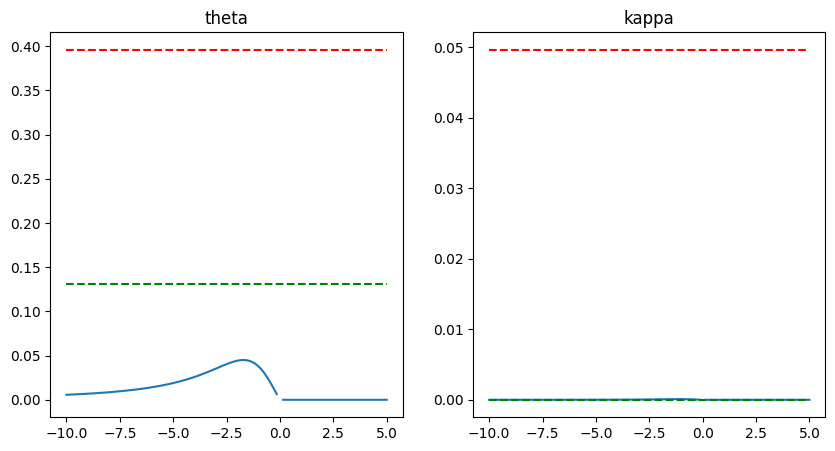

In [17]:
quick_plot(1, 1)

### Domain preparation

In [9]:
subdomain = pp.StructuredTriangleGrid([2*N, 3*N], [2,3])
# convert the grid into a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

In [10]:
key = "flow"

bc_value = []
bc_essential = []
initial_pressure = []

gravity = []

RT0 = pg.RT0(key)
P0  = pg.PwConstants(key)

In [11]:
def g_func(x): 
    return np.array([0, -1, -1])

In [12]:
def initial_pressure_func(x): 
    return 1-x[1]

In [13]:
for subdomain, data in mdg.subdomains(return_data=True):
    g_proj = RT0.interpolate(subdomain, g_func)
    gravity.append(RT0.assemble_mass_matrix(subdomain) @ g_proj)
    initial_pressure.append(P0.interpolate(subdomain, initial_pressure_func))
        
    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions
    gamma_d1 = np.logical_and(subdomain.face_centers[0, :] >= 0, subdomain.face_centers[0, :] <= 1, subdomain.face_centers[1, :] == 3)
    gamma_d2 = np.logical_and(subdomain.face_centers[0, :] == 2, subdomain.face_centers[1, :] >= 0, subdomain.face_centers[1, :] <= 1)

    gamma_d = np.logical_or(gamma_d1, gamma_d2)
    gamma_n = np.logical_not(gamma_d)
    
    def psi_bc(x): return 1

    def bc_gamma_d(x, t):
        if   x[0] == 2 and x[1] >= 0 and x[1] <= 1:
            return 1 - x[1]
        elif x[1] == 3 and x[0] >= 0 and x[0] <= 1:
            if t < dt_D:
                return -2 + 2.2 * t / dt_D
            else:
                return 0.2
        else:
            return 0

    bc_value.append(lambda t: - RT0.assemble_nat_bc(subdomain, lambda x: bc_gamma_d(x,t), gamma_d))

    essential_pressure_dofs = np.zeros(P0.ndof(subdomain), dtype=bool)
    bc_essential.append(np.hstack((gamma_n, essential_pressure_dofs)))

A quick recap:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
k^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
becames, with the time discretization:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
k^{-1}(\psi) {q^{n+1}} + \nabla \psi^{n+1} = -\nabla z\\
\frac{\theta (\psi^{n+1}) - \theta (\psi^{n})}{\Delta t} + \nabla \cdot {q^{n+1}} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

and, with the spacial discretization:

$$
Newton \quad
\left\{
\begin{array}{ll}
\begin{array}{l} 
M^{n+1}_k q_{k+1}^{n+1} + B^T \psi^{n+1}_{k+1} = G^{n+1} - \partial M^{n+1}_k q_k^{n+1}\\
-B q_{k+1}^{n+1} = \frac{\Theta^n - \Theta^{n+1}_k}{\Delta t} - \frac{1}{\Delta t} \partial \Theta^{n+1}_k + F^{n+1}
\end{array}
\end{array}
\right.
$$

$$
Picard \quad
\left\{
\begin{array}{ll}
\begin{array}{l} 
M^{n+1}_k q_{k+1}^{n+1} + B^T \psi^{n+1}_{k+1} = G^{n+1}\\
-B q_{k+1}^{n+1} = \frac{\Theta^n - \Theta^{n+1}_k}{\Delta t} + F^{n+1}
\end{array}
\end{array}
\right.
$$
where:
$$
[M^{n+1}_k]_{ij} = \left( k^{-1}(\psi^{n+1}_k) \Psi, \Psi \right)_{L^2(\Omega)} \qquad [\partial M^{n+1}_k]_{ij} = \left( \frac{\partial k^{-1}}{\partial \psi}(\psi^{n+1}_k) \Psi, \Psi \right)_{L^2(\Omega)}
$$
$$
[\Theta^n]_{ij} = \left( \frac{\theta(\psi^n)}{\Delta t}, \Phi \right)_{L^2(\Omega)} \qquad [\Theta^{n+1}_k]_{ij} = \left( \frac{\theta(\psi^{n+1}_k)}{\Delta t}, \Phi \right)_{L^2(\Omega)} \qquad [\partial \Theta^{n+1}_k]_{ij} = \left( \frac{1}{\Delta t} \frac{\partial \theta(\psi^{n+1}_k)}{\partial \psi}, \Phi \right)_{L^2(\Omega)}
$$

In [14]:
div = pg.cell_mass(mdg) @ pg.div(mdg)

# get the degrees of freedom for each variable
dof_p, dof_q = div.shape
dof_psi = dof_p

In [15]:
def picard(sol_n, t_n_1, prev=None, iters=K):
    if prev == None:
        prev = sol_n.copy()

    # assemble the right-hand side
    fixed_rhs = np.zeros(dof_psi + dof_q)

    # Natural BCs
    fixed_rhs[:dof_q]    += np.hstack(list(cond(t_n_1) for cond in bc_value))

    # Gravity
    fixed_rhs[:dof_q]    += np.hstack(gravity)


    for k in range(iters):

        rhs = fixed_rhs.copy()

        rhs[-dof_psi:] -= pg.cell_mass(mdg) @       theta(prev[-dof_psi:]) / dt
        rhs[-dof_psi:] -= pg.cell_mass(mdg) @ dtheta_dpsi(prev[-dof_psi:]) / dt

        pp.initialize_data(subdomain, data, key, {
            "second_order_tensor": conductivity_tensor(prev[-dof_psi:]),
        })

        # construct the local matrices
        M_k_n_1 = pg.face_mass(mdg)


        # assemble the saddle point problem
        spp = sps.bmat([[M_k_n_1, div.T], 
                        [-div,    None]], format="csc")
        
        # solve the problem
        ls = pg.LinearSystem(spp, rhs)
        ls.flag_ess_bc(np.hstack(bc_essential), np.zeros(dof_q + dof_psi))
    
        current = ls.solve()

        err = np.sum(np.power(current-prev, 2))

        print(f'Time {t_n_1}, Iteration {k}, error L2: {err}')

        if err < eps:
            return current
        else:
            prev = current.copy()
    
    return current

In [16]:
def newton(sol_n, t_n_1, prev=None, iters=K):
    if prev == None:
        prev = sol_n.copy()

    # assemble the right-hand side
    fixed_rhs = np.zeros(dof_psi + dof_q)

    # Natural BCs
    fixed_rhs[:dof_q]    += np.hstack(list(cond(t_n_1) for cond in bc_value))

    # Gravity
    fixed_rhs[:dof_q]    += np.hstack(gravity)

    # Previous time step
    fixed_rhs[-dof_psi:] += pg.cell_mass(mdg) @ theta(sol_n[-dof_psi:]) / dt

    subdomain, data = mdg.subdomains(return_data=True)[0]

    for k in range(iters):

        rhs = fixed_rhs.copy()

        rhs[-dof_psi:] -= pg.cell_mass(mdg) @       theta(prev[-dof_psi:]) / dt
        rhs[-dof_psi:] -= pg.cell_mass(mdg) @ dtheta_dpsi(prev[-dof_psi:]) / dt

        pp.initialize_data(subdomain, data, key, {
            "second_order_tensor": conductivity_tensor(prev[-dof_psi:]),
        })

        # construct the local matrices
        M_k_n_1 = pg.face_mass(mdg)

        pp.initialize_data(subdomain, data, key, {
            "second_order_tensor": dconductivity_tensor_dpsi(prev[-dof_psi:]),
        })
        
        rhs[:dof_q] -= pg.face_mass(mdg) @ prev[:dof_p]


        # assemble the saddle point problem
        spp = sps.bmat([[M_k_n_1, div.T], 
                        [-div,    None]], format="csc")

        # solve the problem
        ls = pg.LinearSystem(spp, rhs)
        ls.flag_ess_bc(np.hstack(bc_essential), np.zeros(dof_q + dof_psi))
    
        current = ls.solve()

        err = np.sum(np.power(current-prev, 2))

        print(f'Time {t_n_1}, Iteration {k}, error L2: {err}')

        if err < eps:
            return current
        else:
            prev = current.copy()
    
    return current

In [17]:
proj_q   = RT0.eval_at_cell_centers(subdomain)
proj_psi =  P0.eval_at_cell_centers(subdomain)

def export_step(save, current_sol, step) -> None:
    q =  current_sol[:dof_q]
    psi = current_sol[-dof_psi:]

    for _, data in mdg.subdomains(return_data=True):
        data[pp.STATE] = {"cell_q": (proj_q @ q).reshape((3, -1), order="F"), 
                          "cell_p": (proj_psi @ psi)}
    
    save.write_vtu(["cell_q", "cell_p"], time_step=step)

In [18]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [19]:
# assemble initial solution
initial_solution = np.zeros(dof_p + dof_q)
initial_solution[-dof_p:] += np.hstack(initial_pressure)

In [20]:
sol = [initial_solution]
save = pp.Exporter(mdg, "sol", folder_name=output_directory)
export_step(save, sol[-1], 0)

# Time Loop
for step in range(1, ceil(T/dt) + 1):
    sol.append( picard(sol[-1], step * dt) )
    export_step(save, sol[-1], step)

save.write_pvd(np.array(range(0, ceil(T/dt) + 1)) * dt)

/home/faccus/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


Time 0.020833333333333332, Iteration 0, error L2: nan
Time 0.020833333333333332, Iteration 1, error L2: nan
Time 0.020833333333333332, Iteration 2, error L2: nan
Time 0.020833333333333332, Iteration 3, error L2: nan
Time 0.020833333333333332, Iteration 4, error L2: nan
Time 0.020833333333333332, Iteration 5, error L2: nan
Time 0.020833333333333332, Iteration 6, error L2: nan
Time 0.020833333333333332, Iteration 7, error L2: nan
Time 0.020833333333333332, Iteration 8, error L2: nan
Time 0.020833333333333332, Iteration 9, error L2: nan
Time 0.020833333333333332, Iteration 10, error L2: nan
Time 0.020833333333333332, Iteration 11, error L2: nan
Time 0.020833333333333332, Iteration 12, error L2: nan
Time 0.020833333333333332, Iteration 13, error L2: nan
Time 0.020833333333333332, Iteration 14, error L2: nan
Time 0.020833333333333332, Iteration 15, error L2: nan
Time 0.020833333333333332, Iteration 16, error L2: nan
Time 0.020833333333333332, Iteration 17, error L2: nan
Time 0.0208333333333

KeyboardInterrupt: 